## AUC as a classifier performance metric in imbalanced setting<sup>*</sup>
---
<sup>*</sup>http://sandeeptata.blogspot.com/2015/04/on-dangers-of-auc.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.metrics import confusion_matrix, auc, roc_curve, roc_auc_score

In [2]:
def collect_metrics(model, threshold):
    """ Calculate performance metrics
    """

    conf_m = confusion_matrix(model['y_test'],
                              model['y_pred_proba'] >= threshold,
                              labels=[0, 1])
    m = dict()
    m['tn'], m['fp'], m['fn'], m['tp'] = conf_m.ravel()

    m['tpr'] = m['tp']/(m['tp'] + m['fn'])
    m['tnr'] = m['tn']/(m['fp'] + m['tn'])
    m['fpr'] = m['fp']/(m['fp'] + m['tn'])
    m['fnr'] = m['fn']/(m['tp'] + m['fn'])

    m['acc'] = (m['tp'] + m['tn'])/(m['tp'] + m['fp'] + m['fn'] + m['tn'])
    m['precision'] = m['tp']/(m['tp'] + m['fp'])
    m['recall'] = m['tp']/(m['tp'] + m['fn'])

    fpr_tmp, tpr_tmp, _ = roc_curve(model['y_test'],
                                    model['y_pred_proba'],
                                    pos_label=1)

    fpr_roc = np.linspace(0, 1, 100)
    m['tpr_roc'] = np.interp(fpr_roc, fpr_tmp, tpr_tmp)
    m['fpr_roc'] = fpr_roc
    m['roc_auc'] = roc_auc_score(model['y_test'],
                                 model['y_pred_proba'],
                                 average='micro')
    
    return m

In [3]:
def visualize_metrics(m):
    """ Visualize the metric object
    """

    roc_label = (f"tpr: {m['tpr']:.2f}, fpr: {m['fpr']:.2f}\n"
                 f"fnr: {m['fnr']:.2f}, tnr: {m['tnr']:.2f}\n"
                 f"accuracy: {m['acc']:.5g}\n"
                 f"precision: {m['precision']:.5g}\n"
                 f"recall: {m['recall']:.5g}\n"
                 f"AUC: {m['roc_auc']:.5g}\n")

    plt.plot(m['fpr_roc'], m['tpr_roc'], label=roc_label)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5))
    plt.fill_between(m['fpr_roc'],
                     m['tpr_roc'],
                     color='silver')

    plt.plot(m['fpr']/(m['fpr'] + m['tnr']),
             m['tpr']/(m['tpr'] + m['fnr']),
             marker='o',
             color='black')

In [4]:
easy_negatives = np.zeros(800)
negatives = np.zeros(100)
positives = np.ones(100)
y_test = np.concatenate([easy_negatives, negatives, positives])

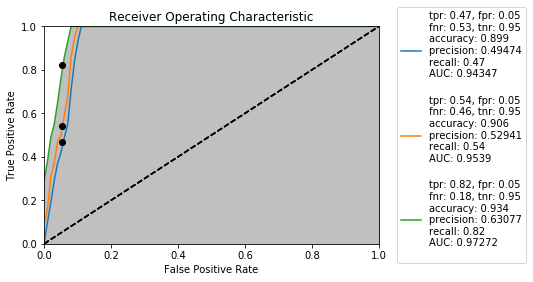

In [5]:
# plt.figure(figsize=(12, 10))
threshold = 0.5

# Uniformly random positives
y_pred_proba_bad = np.concatenate([easy_negatives,
                                   st.uniform.rvs(size=len(negatives) + len(positives))])
visualize_metrics(collect_metrics({'y_test': y_test,
                                   'y_pred_proba': y_pred_proba_bad},
                                  threshold))

# Small leak
y_pred_proba_better = np.clip(y_pred_proba_bad + y_test*0.1, 0, 1)
visualize_metrics(collect_metrics({'y_test': y_test,
                                   'y_pred_proba': y_pred_proba_better},
                                  threshold))

# Bigger leak
y_pred_proba_good = np.clip(y_pred_proba_bad + y_test*0.3, 0, 1)
visualize_metrics(collect_metrics({'y_test': y_test,
                                   'y_pred_proba': y_pred_proba_good},
                                  threshold))